In [1]:
from model import UNet
import torch


In [2]:
def get_device():
    """Get the device to use for PyTorch operations (CPU or cuda or MPS)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using CUDA


In [3]:
model = UNet(
    in_channels=1,
    out_channels=1
).to(device)


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.ShiftScaleRotate(p=0.2),
    A.RandomCrop(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
from datamodule import BinarySegmentationDataset

ds = BinarySegmentationDataset(
    images_dir='../image_generation/generated/stretched/',
    masks_dir='../image_generation/generated/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
)

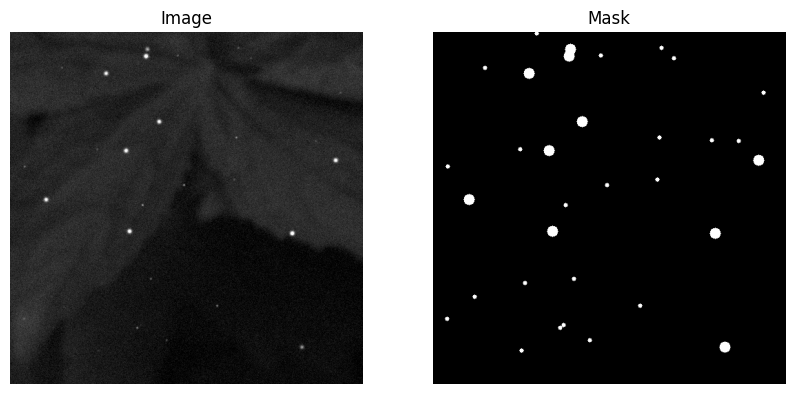

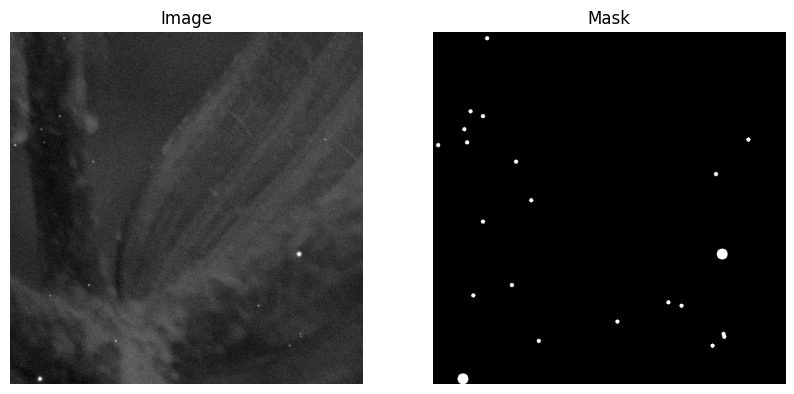

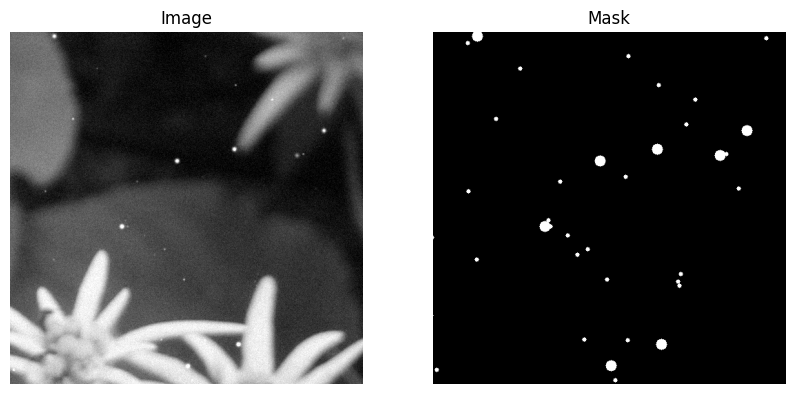

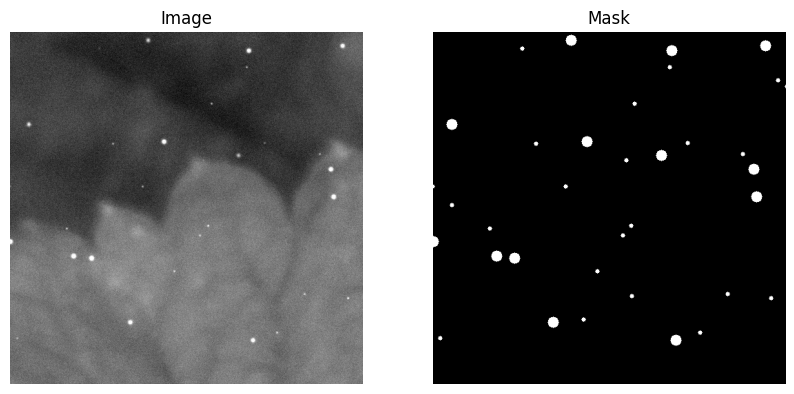

In [6]:
import matplotlib.pyplot as plt
for im, mask in ds:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray')
    axs[1].set_title('Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [7]:
from datamodule import BinarySegmentationDataModule
dm = BinarySegmentationDataModule(
    train_images_dir='../image_generation/generated/stretched/',
    train_masks_dir='../image_generation/generated/masks/',
    val_images_dir='../image_generation/generated/stretched/',
    val_masks_dir='../image_generation/generated/masks/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(512, 512),
    batch_size=2,
    num_workers=0,      # SE aumento il numero di workers, va molto più lento
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [8]:
for images, masks in train_loader:
    print(images.shape)  
    print(masks.shape)   
    

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])


In [9]:
model = UNet(
    in_channels=1,
    out_channels=1
).to(device)


In [10]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/100], Loss: 1.0000
Epoch [2/100], Loss: 0.9743
Epoch [3/100], Loss: 1.0259
Epoch [4/100], Loss: 0.9496
Epoch [5/100], Loss: 0.8649
Epoch [6/100], Loss: 0.8744
Epoch [7/100], Loss: 0.9046
Epoch [8/100], Loss: 0.8566
Epoch [9/100], Loss: 0.7386
Epoch [10/100], Loss: 0.7367
Epoch [11/100], Loss: 0.8017
Epoch [12/100], Loss: 0.7553
Epoch [13/100], Loss: 0.7240
Epoch [14/100], Loss: 0.7316
Epoch [15/100], Loss: 0.6565
Epoch [16/100], Loss: 0.6947
Epoch [17/100], Loss: 0.7488
Epoch [18/100], Loss: 0.7677
Epoch [19/100], Loss: 0.6723
Epoch [20/100], Loss: 0.5882
Epoch [21/100], Loss: 0.8660
Epoch [22/100], Loss: 0.7434
Epoch [23/100], Loss: 0.9294
Epoch [24/100], Loss: 0.6928
Epoch [25/100], Loss: 0.7707
Epoch [26/100], Loss: 0.6229
Epoch [27/100], Loss: 0.6496
Epoch [28/100], Loss: 0.5660
Epoch [29/100], Loss: 0.6412
Epoch [30/100], Loss: 0.5733
Epoch [31/100], Loss: 0.5408
Epoch [32/100], Loss: 0.4277
Epoch [33/100], Loss: 0.3463
Epoch [34/100], Loss: 0.6149
Epoch [35/100], Loss: 0

In [11]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.1287
Epoch [2/30], Loss: 0.3002
Epoch [3/30], Loss: 0.3142
Epoch [4/30], Loss: 0.1725
Epoch [5/30], Loss: 0.1947
Epoch [6/30], Loss: 0.2233
Epoch [7/30], Loss: 0.3024
Epoch [8/30], Loss: 0.1797
Epoch [9/30], Loss: 0.1844
Epoch [10/30], Loss: 0.1703
Epoch [11/30], Loss: 0.1514
Epoch [12/30], Loss: 0.1795
Epoch [13/30], Loss: 0.1606
Epoch [14/30], Loss: 0.1488
Epoch [15/30], Loss: 0.1613
Epoch [16/30], Loss: 0.1557
Epoch [17/30], Loss: 0.1403
Epoch [18/30], Loss: 0.1893
Epoch [19/30], Loss: 0.1867
Epoch [20/30], Loss: 0.1780
Epoch [21/30], Loss: 0.1626
Epoch [22/30], Loss: 0.1506
Epoch [23/30], Loss: 0.2298
Epoch [24/30], Loss: 0.1325
Epoch [25/30], Loss: 0.2858
Epoch [26/30], Loss: 0.1398
Epoch [27/30], Loss: 0.2612
Epoch [28/30], Loss: 0.1507
Epoch [29/30], Loss: 0.1515
Epoch [30/30], Loss: 0.2371


In [12]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.1325
Epoch [2/30], Loss: 0.1466
Epoch [3/30], Loss: 0.1618
Epoch [4/30], Loss: 0.1315
Epoch [5/30], Loss: 0.1243
Epoch [6/30], Loss: 0.2372
Epoch [7/30], Loss: 0.1842
Epoch [8/30], Loss: 0.2263
Epoch [9/30], Loss: 0.1993
Epoch [10/30], Loss: 0.1757
Epoch [11/30], Loss: 0.1195
Epoch [12/30], Loss: 0.1438
Epoch [13/30], Loss: 0.2211
Epoch [14/30], Loss: 0.2575
Epoch [15/30], Loss: 0.1419
Epoch [16/30], Loss: 0.1916
Epoch [17/30], Loss: 0.1633
Epoch [18/30], Loss: 0.2308
Epoch [19/30], Loss: 0.1398
Epoch [20/30], Loss: 0.1521
Epoch [21/30], Loss: 0.1740
Epoch [22/30], Loss: 0.2168
Epoch [23/30], Loss: 0.1726
Epoch [24/30], Loss: 0.2649
Epoch [25/30], Loss: 0.1669
Epoch [26/30], Loss: 0.2797
Epoch [27/30], Loss: 0.2052
Epoch [28/30], Loss: 0.1360
Epoch [29/30], Loss: 0.1922
Epoch [30/30], Loss: 0.1425


In [15]:
# save model
torch.save(model.state_dict(), 'checkpoints/seg__gen_0.pth')

In [16]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0617
Epoch [2/10], Loss: 0.0436
Epoch [3/10], Loss: 0.0509
Epoch [4/10], Loss: 0.0385
Epoch [5/10], Loss: 0.0804
Epoch [6/10], Loss: 0.0795
Epoch [7/10], Loss: 0.0660
Epoch [8/10], Loss: 0.0617
Epoch [9/10], Loss: 0.0394
Epoch [10/10], Loss: 0.0586


In [22]:
# save model
torch.save(model.state_dict(), 'checkpoints/seg__gen_1.pth')

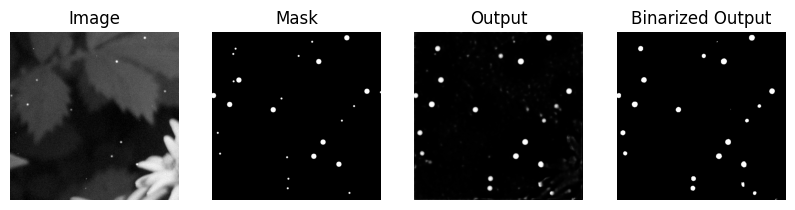

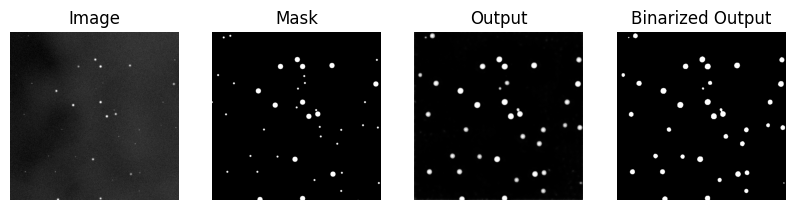

In [28]:
model.eval()
with torch.no_grad():
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed
        loss = criterion(outputs, masks)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.5).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Binarized Output')
        plt.axis('off')